In [6]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [7]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=4.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_original = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints,
        name="x_original"), reinterpreted_batch_ndims=2)
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)

def probabilistic_pca_orig(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x_original = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints,
        name="x_original"), reinterpreted_batch_ndims=2)
    
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=4.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)

def probabilistic_pca_onlymu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=4.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)

In [8]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)


In [12]:
actual_w, actual_z, actual_mu, x_orig_train, x_mu_train = model_basis.sample()

print("Principal axes:")
print(actual_w)
print(actual_z)

Principal axes:
tf.Tensor(
[[-3.3108666]
 [ 0.836019 ]], shape=(2, 1), dtype=float32)
tf.Tensor([[ 0.5851184  1.7422022  1.7218431 ...  3.7737079 -0.8732959  1.062576 ]], shape=(1, 5000), dtype=float32)


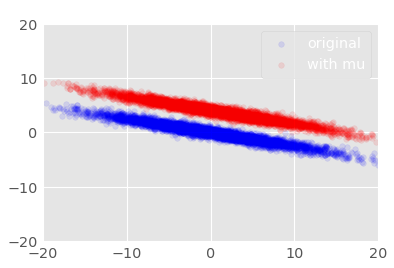

In [13]:
plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='original')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='red', alpha=0.1,label='with mu')
plt.axis([-20, 20, -20, 20])
plt.legend()
plt.title("Data set")
plt.show()

In [17]:
concrete_ppca_model_orig = functools.partial(probabilistic_pca_orig,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_orig = tfd.JointDistributionCoroutine(concrete_ppca_model_orig)

concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

concrete_ppca_model_onlymu = functools.partial(probabilistic_pca_onlymu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_onlymu = tfd.JointDistributionCoroutine(concrete_ppca_model_onlymu)

In [18]:
w_orig = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_orig = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn_orig = lambda w_orig, z_orig: model_orig.log_prob((w_orig, z_orig, x_orig_train))
losses_orig = tfp.math.minimize(lambda: -target_log_prob_fn_orig(w_orig, z_orig),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

In [19]:
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.Variable(np.ones([data_dim,1]), dtype=tf.float32)

target_log_prob_fn_onlymu = lambda mu_mu: model_onlymu.log_prob((mu_mu, x_mu_train))
losses_onlymu = tfp.math.minimize(lambda: -target_log_prob_fn_onlymu(mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

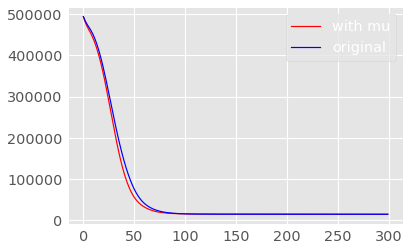

In [20]:
plt.plot(losses_mu[:,0], label='with mu', color='red')
plt.plot(losses_orig, label='original', color='blue')
plt.legend()
plt.show()

Original model:
MAP-estimated axes:
actual W:  tf.Tensor(
[[-3.3108666]
 [ 0.836019 ]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 3.796905 ],
       [-0.9560506]], dtype=float32)>

actual Z:  tf.Tensor([[ 0.5851184  1.7422022  1.7218431 ...  3.7737079 -0.8732959  1.062576 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dtype=float32, numpy=
array([[-0.57758296, -1.5157309 , -1.5172153 , ..., -3.3364701 ,
         0.7627299 , -0.68324673]], dtype=float32)>

MAP-estimated axes:
actual W:  tf.Tensor(
[[-3.3108666]
 [ 0.836019 ]], shape=(2, 1), dtype=float32)
Estimated W:  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 3.7576253],
       [-0.9476441]], dtype=float32)>

actual Z:  tf.Tensor([[ 0.5851184  1.7422022  1.7218431 ...  3.7737079 -0.8732959  1.062576 ]], shape=(1, 5000), dtype=float32)
Estimated Z:  <tf.Variable 'Variable:0' shape=(1, 5000) dtyp

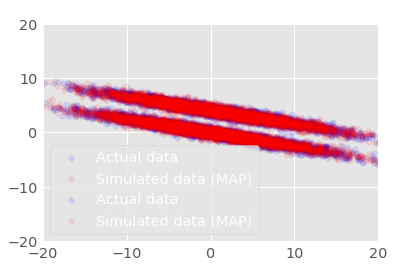

In [22]:
print('Original model:')
print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_orig)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_orig)
print()

_, _, x_generated_orig = model_orig.sample(value=(w_orig, z_orig, None))

plt.scatter(x_orig_train[0, :], x_orig_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_orig[0, :], x_generated_orig[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
# plt.legend()
# plt.title('Original model')
# plt.axis([-20, 20, -20, 20])
# plt.show()

print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_mu)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_mu)
print()
print('actual mu: ',actual_mu)
print('Estimated mu: ',mu_mu)

_, _, _, x_generated_mu = model_mu.sample(value=(w_mu, z_mu, mu_mu, None))

plt.scatter(x_mu_train[0, :], x_mu_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.title('Model with mu')
plt.axis([-20, 20, -20, 20])
plt.show()

# Variational Inference

In [23]:
qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qmu_mean = tf.Variable(np.ones([data_dim, 1]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))
qmu_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, 1]), dtype=tf.float32))

def factored_normal_variational_model():
    qw = yield Root(tfd.Independent(tfd.Normal(
        loc=qw_mean, scale=qw_stddv, name="qw"), reinterpreted_batch_ndims=2))
    qz = yield Root(tfd.Independent(tfd.Normal(
        loc=qz_mean, scale=qz_stddv, name="qz"), reinterpreted_batch_ndims=2))
    qmu = yield Root(tfd.Independent(tfd.Normal(
        loc=qmu_mean, scale=qmu_stddv, name="qmu"), reinterpreted_batch_ndims=1))

surrogate_posterior = tfd.JointDistributionCoroutine(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[3.2071447],
       [2.6954572]], dtype=float32)>
Standard Deviation:
tf.Tensor(
[[0.01814996]
 [0.01814996]], shape=(2, 1), dtype=float32)


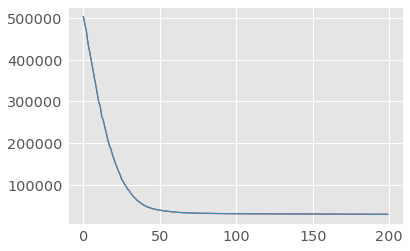

In [24]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

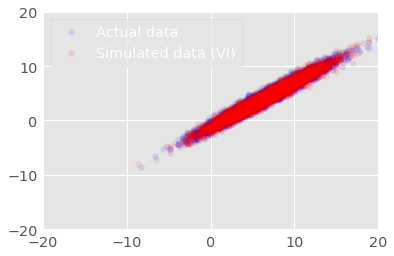

In [25]:
posterior_samples = surrogate_posterior.sample(50)
_, _, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()